In [1]:
import kagglehub
import shutil
# Download latest version
path = kagglehub.dataset_download("kshitij192/cars-image-dataset")
print("Path to dataset files:", path)
shutil.copytree(path, '/content/sample_data', dirs_exist_ok=True)

Path to dataset files: /kaggle/input/cars-image-dataset


'/content/sample_data'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
import urllib.request
import tarfile
import matplotlib.pyplot as plt

In [3]:
modelName = "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
modelTar = f"{modelName}.tar.gz"
MODEL_URL = f"http://download.tensorflow.org/models/object_detection/tf2/20200711/{modelTar}"

In [4]:
if not os.path.exists(modelTar):
  urllib.request.urlretrieve(MODEL_URL,modelTar)
if not os.path.exists(modelName):
  tar = tarfile.open(modelTar)
  tar.extractall()
  tar.close()

In [5]:
model = tf.saved_model.load(f"{modelName}/saved_model") #object detection model

In [6]:
# labels for object detector
LABELS_URL = "https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt"
LABELS_FILE = "mscoco_label_map.pbtxt"
if not os.path.exists(LABELS_FILE):
    urllib.request.urlretrieve(LABELS_URL, LABELS_FILE)

def load_labels(path):
    category_index = {}
    with open(path, "r") as f:
        lines = f.readlines()
        for line in lines:
            if "id:" in line:
                id = int(line.split(":")[1].strip())
                name = lines[lines.index(line) + 1].split(":")[1].strip().replace('"', "")
                category_index[id] = name
    return category_index

category_index = load_labels(LABELS_FILE)
#for i in range(len(category_index)):
#  print(f"{i} : {category_index.get(i, 'not found')}")

In [18]:
def detectObj(img):
    image = img_array = np.array(img)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = tf.convert_to_tensor(image_rgb)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = model(input_tensor)

    # Get boxes, scores, and classes
    num_detections = int(detections.pop("num_detections"))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections["num_detections"] = num_detections
    detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

    croppedCars=[]
    # Draw boxes on the image
    for i in range(num_detections):
        confidence = detections["detection_scores"][i]
        if confidence > 0.5:  # Confidence threshold
            box = detections["detection_boxes"][i]
            class_id = detections["detection_classes"][i]
            label = category_index.get(class_id, "Unknown")
            h, w, _ = image.shape
            y1, x1, y2, x2 = int(box[0] * h), int(box[1] * w), int(box[2] * h), int(box[3] * w)
            croppedCar = image[y1:y2, x1:x2]  # still in BGR
            croppedCars.append(croppedCar)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"{label}: {confidence:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Show the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    return croppedCars


In [14]:
def detect_objects(image_path):
    image =
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = tf.convert_to_tensor(image_rgb)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = model(input_tensor)

    # Get boxes, scores, and classes
    num_detections = int(detections.pop("num_detections"))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections["num_detections"] = num_detections
    detections["detection_classes"] = detections["detection_classes"].astype(np.int64)

    croppedCars=[]
    # Draw boxes on the image
    for i in range(num_detections):
        confidence = detections["detection_scores"][i]
        if confidence > 0.5:  # Confidence threshold
            box = detections["detection_boxes"][i]
            class_id = detections["detection_classes"][i]
            label = category_index.get(class_id, "Unknown")
            h, w, _ = image.shape
            y1, x1, y2, x2 = int(box[0] * h), int(box[1] * w), int(box[2] * h), int(box[3] * w)
            croppedCar = image[y1:y2, x1:x2]  # still in BGR
            croppedCars.append(croppedCar)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"{label}: {confidence:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Show the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    return croppedCars

Processing 208.jpg...


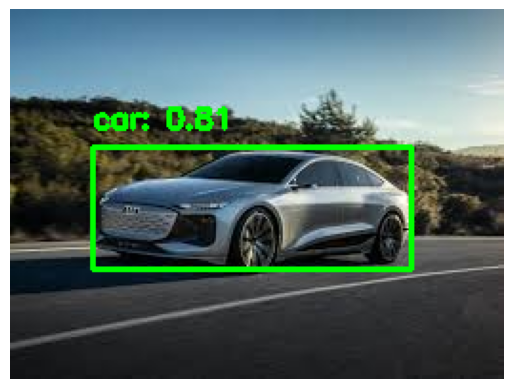


Processing 317.jpg...


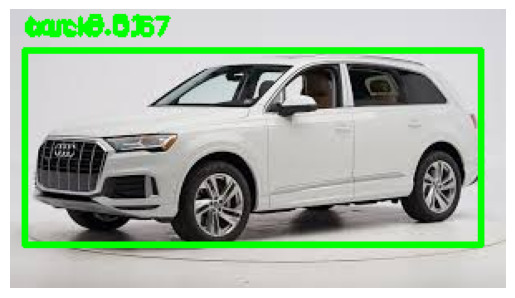


Processing 695.jpg...


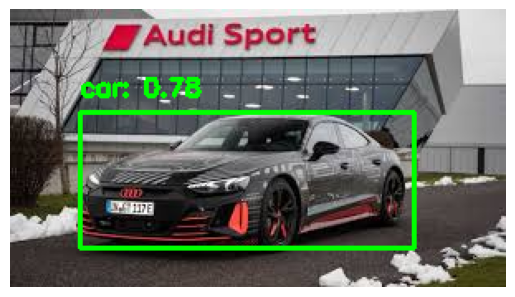


Processing 688.jpg...


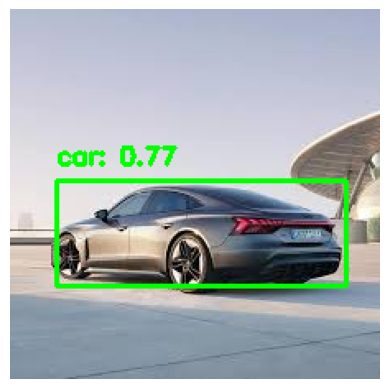


Processing 263.jpg...


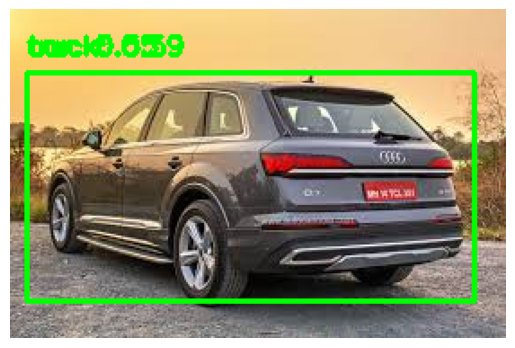

In [ ]:
# test detector
testSet = '/content/sample_data/Cars Dataset/test/Audi'

count = 0
limit = 5

for filename in os.listdir(testSet):
  if count < limit:
      if filename.endswith((".jpg", ".png", ".jpeg")):
        print(f"Processing {filename}...")
        detect_objects(os.path.join(testSet, filename))
        print()
        count+=1


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image


In [ ]:
# train the classificator of car models

testSet = '/content/sample_data/Cars Dataset/test'
trainSet = '/content/sample_data/Cars Dataset/train'
imgSz = (300,168)

def preprocess_image(image, label, target_size=(224, 224)):
    image = tf.image.resize_with_pad(image, target_size[0], target_size[1])
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    return image, label

def trainClassifier(trainDir:str, valDir:str, imgSize:int=(224,224), batch_size:int=32):

  trainDS = tf.keras.preprocessing.image_dataset_from_directory(
      trainDir,
      image_size=imgSize,
      batch_size=batch_size
  )
  valDS = tf.keras.preprocessing.image_dataset_from_directory(
      valDir,
      image_size=imgSize,
      batch_size=batch_size
  )

  trainDS = trainDS.map(lambda x, y: preprocess_image(x, y, (224,224)))
  valDS = valDS.map(lambda x, y: preprocess_image(x, y, (224,224)))

  trainDS = trainDS.prefetch(tf.data.AUTOTUNE)
  valDS=valDS.prefetch(tf.data.AUTOTUNE)

  baseModel = tf.keras.applications.MobileNetV2(
      input_shape=(224,224, 3),
      include_top=False,
      weights='imagenet'
  )
  baseModel.trainable=False
  model = tf.keras.Sequential([
      baseModel,
      layers.GlobalAveragePooling2D(),
      layers.Dense(128, activation='relu'),
      layers.Dense(trainDS.cardinality().numpy(), activation='softmax')
  ])
  model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  history = model.fit(trainDS, validation_data=valDS, epochs=10)
  return model, history

classfierModel, classifierModelHistory = trainClassifier(trainSet, testSet, imgSz)

In [ ]:
classfierModel.save("car_model_classifier.keras")

In [17]:
def webImageLoader(link):
  headers = {
        "User-Agent": "Mozilla/5.0"
  }
  img_url = link  # Replace with the actual URL
  # Fetch the image from the web
  response = requests.get(img_url, headers=headers)
  # Open the image from the fetched content
  img = Image.open(BytesIO(response.content)).convert('RGB')
  img = img.resize((224, 224))  # Same as your model's input size
  return img
def imageLoader(path):
  img_path = "/content/2022_Toyota_Kijang_Innova_2.4_G_GUN142R_(20220302).jpg"   # your image path
  img = image.load_img(img_path, target_size=(224, 224))  # same as training size
  return img
def webImageLoaderToDetector(link): #doesn't crop image
  headers = {
        "User-Agent": "Mozilla/5.0"
  }
  img_url = link
  response = requests.get(img_url, headers=headers)
  img = Image.open(BytesIO(response.content)).convert('RGB')
  return img
def convertToArray(img):
  img_array = image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # shape becomes (1, 224, 224, 3)
  img_array = img_array / 255.0  # normalize if model was trained this way
  return img_array

Found 813 files belonging to 7 classes.
['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: Audi (0.36)


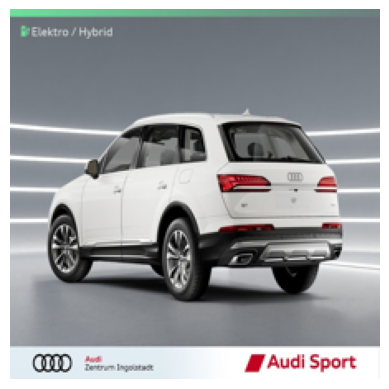

In [24]:
# test the classifier
classifierModel = tf.keras.models.load_model('car_model_classifier.keras')
testDir = '/content/sample_data/Cars Dataset/test'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testDir,
    image_size=(224, 224),
    batch_size=32
)

class_names = test_ds.class_names
print(class_names)
path='https://www.audi-zentrum-ingolstadt.de/media/mobile/img_18865_5_i367032471600x1200.jpg'
img=webImageLoader(path)
img_array = convertToArray(img)
pred = classifierModel.predict(img_array)

predicted_class_index = np.argmax(pred[0])
confidence = pred[0][predicted_class_index]

# 5. If you have class names from dataset
predicted_class_name = class_names[predicted_class_index]

# 6. Print result
print(f"Predicted: {predicted_class_name} ({confidence:.2f})")
plt.imshow(img)
plt.axis('off')  # Optional: hides axes
plt.show()

In [ ]:
def pipeline(path):
  img = webImageLoaderToDetector(path)
  cropped = detectObj(img)
  for car in cropped:
    img_array = convertToArray(car)
    pred = classifierModel.predict(img_array)
    predicted_class_index = np.argmax(pred[0])
    confidence = pred[0][predicted_class_index]
    predicted_class_name = class_names[predicted_class_index]
    print(f"Predicted: {predicted_class_name} ({confidence:.2f})")
    plt.imshow(car)
    plt.axis('off')  # Optional: hides axes
    plt.show()

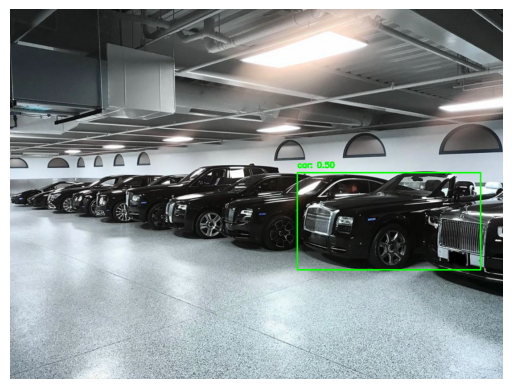

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted: Rolls Royce (0.99)


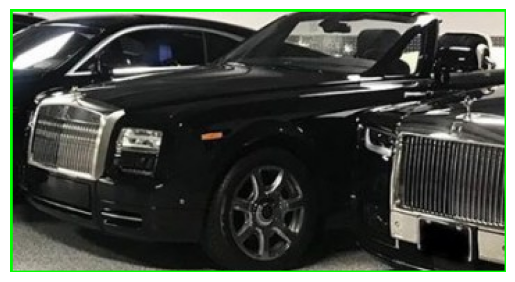

In [62]:
#test pipeline
tests = [
    {
        "id":1,
        "link": 'https://hertsrollers.com//wp-content/uploads/2014/10/rolls-royce-ghost-white14.jpg',
        "desc": "two rolls royces"
    },
    {
        "id":2,
        "link": 'https://live.staticflickr.com/5595/14632220337_d1524ffc20_b.jpg',
        "desc": "parking lot merc+audi+rr"
    },
    {
        "id":3,
        "link": 'https://www.audi-zentrum-ingolstadt.de/media/mobile/img_18865_5_i367032471600x1200.jpg',
    },
    {
        "id":4,
        "link": 'https://s1.cdn.autoevolution.com/images/news/audi-q8-with-suicide-doors-copies-rolls-royce-isn-t-real-134725_1.jpg',
        "desc": "audi open door"
    },
    {
        "id":5,
        "link": 'https://media.drive.com.au/obj/tx_q:50,rs:auto:1920:1080:1/driveau/upload/cms/uploads/gbsc1wlhrtwugy0laiwx',
        "desc": "bunch of rolls royces"
    },
    {
        'id':6,
        'link':'https://www.thesun.co.uk/wp-content/uploads/2019/10/NINTCHDBPICT000527661803.jpg?strip=all&w=960',
        'desc':'a garage full of rolls royces'
    },
    {
        'id':7,
        'link':'https://codevlabs.com/api/cup/uploads/5/1609249566.jpg',
        'desc':'old school rolls royce. Probably was not in training set!'
    },
    {
        'id':8,
        'link':'https://i.redd.it/uoby19lildd91.jpg',
        'desc':'garage of audis'
    },
    {
        'id':9,
        'link':'https://www.r8talk.com/attachments/image_picker_334a0cb8-91da-4421-8963-8d81e008dacd-60336-00002d87e499ff5f-jpg.302480/',
        'desc':'two audis in a garage back. Issues when loading'
    }

]
pipeline(tests[5]['link'])